In [1]:
# Import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels
import sklearn 
from collections import defaultdict
import pandas as pd
from surprise import SVD
from surprise import Dataset
from surprise import evaluate, print_perf
from surprise import Reader
from surprise import KNNBasic

# iPython command to format matplotlib plots
%matplotlib inline

In [2]:
import json

'''
load_data(filepath) 
Given a filepath to a JSON file, loads in the file and formats the JSON
'''
def load_data(filepath,n_samples):
    data = []
    count = 0
    # Open file and read in line by line
    with open(filepath) as file:
        for line in file:
            # Strip out trailing whitespace at the end of the line
            data.append(json.loads(line.rstrip()))
            count +=1
            if count == n_samples:
                break
            else:
                pass
    print "Data with {} entries laodad".format(count)
    return data

In [3]:
data = load_data("review.json",n_samples=50000)

Data with 50000 entries laodad


**review.json**
Contains full review text data including the user_id that<br>
wrote the review and the business_id the review is written for.<br>

{

    // string, 22 character unique review id
    "review_id": "zdSx_SD6obEhz9VrW9uAWA",

    // string, 22 character unique user id, maps to the user in user.json
    "user_id": "Ha3iJu77CxlrFm-vQRs_8g",

    // string, 22 character business id, maps to business in business.json
    "business_id": "tnhfDv5Il8EaGSXZGiuQGg",

    // integer, star rating
    "stars": 4,

    // string, date formatted YYYY-MM-DD
    "date": "2016-03-09",

    // string, the review itself
    "text": "Great place to hang out after work: the prices are decent, and the ambience is fun. It's a bit loud, but very lively. The staff is friendly, and the food is good. They have a good selection of drinks.",

    // integer, number of useful votes received
    "useful": 0,

    // integer, number of funny votes received
    "funny": 0,

    // integer, number of cool votes received
    "cool": 0
    
}


In [4]:
df = pd.DataFrame(data=data)
df.head()

,business_id,cool,date,funny,review_id,stars,text,useful,user_id
0,uYHaNptLzDLoV_JZ_MuzUA,0,2016-07-12,0,VfBHSwC5Vz_pbFluy07i9Q,5,My girlfriend and I stayed here for 3 nights a...,0,cjpdDjZyprfyDG3RlkVG3w
1,uYHaNptLzDLoV_JZ_MuzUA,0,2016-10-02,0,3zRpneRKDsOPq92tq7ybAA,3,If you need an inexpensive place to stay for a...,0,bjTcT8Ty4cJZhEOEo01FGA
2,uYHaNptLzDLoV_JZ_MuzUA,0,2015-09-17,0,ne5WhI1jUFOcRn-b-gAzHA,3,Mittlerweile gibt es in Edinburgh zwei Ableger...,0,AXgRULmWcME7J6Ix3I--ww
3,uYHaNptLzDLoV_JZ_MuzUA,0,2016-08-21,0,llmdwOgDReucVoWEry61Lw,4,Location is everything and this hotel has it! ...,0,oU2SSOmsp_A8JYI7Z2JJ5w
4,uYHaNptLzDLoV_JZ_MuzUA,0,2013-11-20,0,DuffS87NaSMDmIfluvT83g,5,gute lage im stadtzentrum. shoppingmeile und s...,0,0xtbPEna2Kei11vsU-U2Mw


In [5]:
#lets get an overview of our numerical predictors coolness,funniness,usefulness and rating
df.describe()

,cool,funny,stars,useful
count,50000.000000,50000.000000,50000.000000,50000.000000
mean,0.545500,0.418240,3.768300,1.013140
std,2.022575,1.620965,1.399262,2.447988
min,0.000000,0.000000,1.000000,0.000000
25%,0.000000,0.000000,3.000000,0.000000
50%,0.000000,0.000000,4.000000,0.000000
75%,0.000000,0.000000,5.000000,1.000000
max,104.000000,65.000000,5.000000,99.000000


In [6]:
print "Number of unique businesses:",len(df.business_id.unique())
print "Number of unique users:",len(df.user_id.unique())
print "Number of total reviews:",len(df)

Number of unique businesses: 1998
Number of unique users: 42744
Number of total reviews: 50000


In [7]:
star_groups = df.stars.value_counts()
star_groups = star_groups.sort_index()

Text(0,0.5,u'Count')

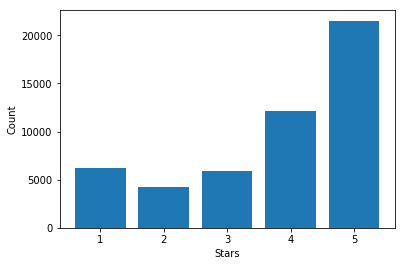

In [8]:
fix,ax = plt.subplots()
ax.bar(star_groups.index,star_groups.values)
ax.set_xlabel("Stars")
ax.set_ylabel("Count")

In [9]:
surprise_df = df[['user_id','business_id','stars']]
#surprise_df.columns = ['userID' ,'itemID', 'rating'] #renaming the columns

In [10]:
# A reader is still needed but only the rating_scale param is requiered.
reader = Reader(rating_scale=(1, 5))
# The columns must correspond to user id, item id and ratings (in that order).
data = Dataset.load_from_df(surprise_df, reader)
data.split(n_folds=3)  # data can now be used normally

In [11]:
# We'll use the SVD algorithm.
algo = SVD()

# Evaluate performances of our algorithm on the dataset.
perf = evaluate(algo, data, measures=['RMSE', 'MAE'])

print_perf(perf)

Evaluating RMSE, MAE of algorithm SVD.

------------
Fold 1
RMSE: 1.2647
MAE:  1.0190
------------
Fold 2
RMSE: 1.2768
MAE:  1.0304
------------
Fold 3
RMSE: 1.2801
MAE:  1.0299
------------
------------
Mean RMSE: 1.2739
Mean MAE : 1.0264
------------
------------
        Fold 1  Fold 2  Fold 3  Mean    
MAE     1.0190  1.0304  1.0299  1.0264  
RMSE    1.2647  1.2768  1.2801  1.2739  


In [12]:
# Now let us predict but before that we have to train

# Retrieve the trainset the algo above
trainset = data.build_full_trainset()
algo.train(trainset)

In [13]:
case1 = surprise_df.values[12922]
case2 = surprise_df.values[8932]
print case1
print case2

[u'eB-ryqGBIVeNL0-mm88r0g' u'0jHZk9RrKh0uRhTRW1XIqQ' 5]
[u'bK5l6tLywoLXZ9Nf9By3Uw' u'tulUhFYMvBkYHsjmn30A9w' 3]


In [14]:
#Let us predict for the above scenario: userID and businessID and ground truth of 5 stars
##################### CASE 1 #########################
user_id = case1[0]  # raw user id (as in the ratings file)
item_id = case1[1]  # raw item id (as in the ratings file)
true_rating = case1[2] # true rating of the pair
# get a prediction for specific users and items.
pred = algo.predict(user_id, item_id, r_ui=true_rating, verbose=True)
##################### CASE 2 #########################
user_id = case2[0]  # raw user id (as in the ratings file)
item_id = case2[1]  # raw item id (as in the ratings file)
true_rating = case2[2] # true rating of the pair
# get a prediction for specific users and items.
pred = algo.predict(user_id, item_id, r_ui=true_rating, verbose=True)

user: eB-ryqGBIVeNL0-mm88r0g item: 0jHZk9RrKh0uRhTRW1XIqQ r_ui = 5.00   est = 4.66   {u'was_impossible': False}
user: bK5l6tLywoLXZ9Nf9By3Uw item: tulUhFYMvBkYHsjmn30A9w r_ui = 3.00   est = 3.06   {u'was_impossible': False}


In [15]:
#Lets have a look at what we recommended as most similar to a given business

In [16]:
business = load_data("business.json",n_samples=100000)
user = load_data('user.json',n_samples=100000)

Data with 100000 entries laodad
Data with 100000 entries laodad


In [17]:
business_df = pd.DataFrame(data=business)
user_df = pd.DataFrame(data=user)

In [18]:
print business_df.columns
print user_df.columns
print df.columns

Index([u'address', u'attributes', u'business_id', u'categories', u'city',
       u'hours', u'is_open', u'latitude', u'longitude', u'name',
       u'neighborhood', u'postal_code', u'review_count', u'stars', u'state'],
      dtype='object')
Index([u'average_stars', u'compliment_cool', u'compliment_cute',
       u'compliment_funny', u'compliment_hot', u'compliment_list',
       u'compliment_more', u'compliment_note', u'compliment_photos',
       u'compliment_plain', u'compliment_profile', u'compliment_writer',
       u'cool', u'elite', u'fans', u'friends', u'funny', u'name',
       u'review_count', u'useful', u'user_id', u'yelping_since'],
      dtype='object')
Index([u'business_id', u'cool', u'date', u'funny', u'review_id', u'stars',
       u'text', u'useful', u'user_id'],
      dtype='object')


In [19]:
sim_options = {'name': 'cosine',
               'user_based': False } # compute  similarities between businesses
algoKNN = KNNBasic(k=1)
algoKNN.train(trainset)

Computing the msd similarity matrix...
Done computing similarity matrix.


In [32]:
# Let us investigate the given business below and find its most similar one
business_case_id = str(df.business_id.loc[17329])
print business_case_id
unique_businesses = pd.DataFrame(df.business_id.unique(),columns=['business_id'])
business_case_idx = unique_businesses.loc[unique_businesses.business_id == business_case_id].index.values[0]
#print business_case_idx
print business_case_idx

jalA5zHW8ZfY3RSPG7oDxQ
496


In [34]:
neighbor_business_idx = algoKNN.get_neighbors(business_case_idx,k=1)[0]

In [35]:
neighbor_business_id = str(unique_businesses.iloc[neighbor_business_idx][0])
print business_case_id
print neighbor_business_id

jalA5zHW8ZfY3RSPG7oDxQ
ShnXvNkJKsDIQaGJeM0L6w


In [36]:
#Lets compare both business
business_df.loc[business_df['business_id'] == business_case_id]


,address,attributes,business_id,categories,city,hours,is_open,latitude,longitude,name,neighborhood,postal_code,review_count,stars,state
29091,1107 E Carson St,"{u'GoodForMeal': {u'dessert': False, u'latenig...",jalA5zHW8ZfY3RSPG7oDxQ,"[French, Mediterranean, Restaurants]",Pittsburgh,"{u'Tuesday': u'11:00-14:00', u'Friday': u'11:0...",1,40.428895,-79.987145,Cafe Du Jour,South Side,15203,142,4.5,PA


In [37]:
#and its neighbor
business_df.loc[business_df['business_id'] == neighbor_business_id]

,address,attributes,business_id,categories,city,hours,is_open,latitude,longitude,name,neighborhood,postal_code,review_count,stars,state
2338,"4520 N Tryon St, Ste 25","{u'GoodForMeal': {u'dessert': False, u'latenig...",ShnXvNkJKsDIQaGJeM0L6w,"[Chinese, Food, Meat Shops, Restaurants, Barbe...",Charlotte,"{u'Monday': u'10:00-20:00', u'Tuesday': u'10:0...",0,35.256185,-80.791179,Hong Kong BBQ,NoDa,28213,7,4.0,NC


In [38]:
# So we can see above that both business have similar catoegories and the same attributes